### Dependencies and imports

In [ ]:
!pip3 install torch torchvision
!pip3 install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

### Load images


In [ ]:
imsize = 400

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style1_img = image_loader("style1.jpeg")
style2_img = image_loader("style5.jpeg")
content_img = image_loader("content1.jpeg")

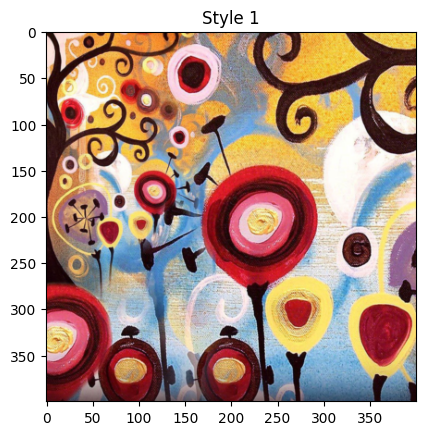

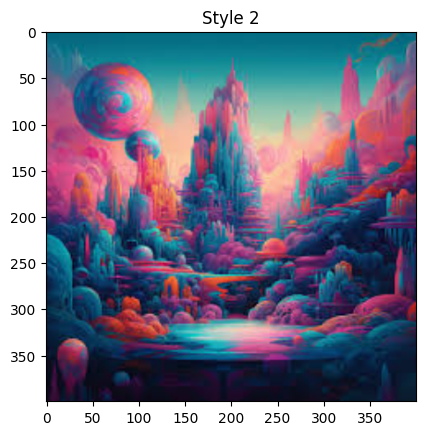

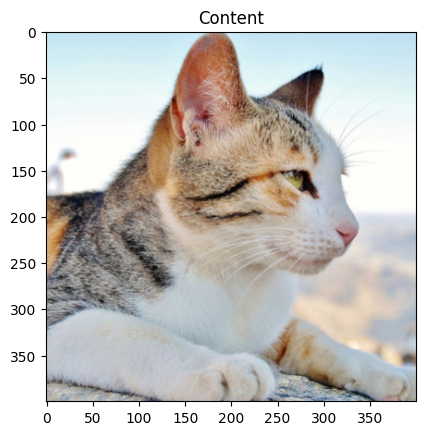

In [ ]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style1_img, title='Style 1')

plt.figure()
imshow(style2_img, title='Style 2')

plt.figure()
imshow(content_img, title='Content')

### Style loss and Content loss

In [ ]:
class ContentLoss(nn.Module):
        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [ ]:
def gram_matrix(input):
        batch_size, h, w, f_map_num = input.size()
        features = input.view(batch_size * h, w * f_map_num)
        G = torch.mm(features, features.t())
        return G.div(batch_size * h * w * f_map_num)

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target_features):
            super(StyleLoss, self).__init__()
            self.target_gram_matrices = []
            self.target_features = target_features
            self.loss = torch.zeros(2)

        def forward(self, input):
            G = []

            mask2 = torch.zeros(1, 1, input.size()[2], input.size()[2])
            mask2[:, :, :, 0:(input.size()[2] // 2)] = 1
            new_mask2 = mask2.repeat(1,input.size()[1],1,1).to(device)

            mask1 = torch.zeros(1, 1, input.size()[2], input.size()[2])
            mask1[:, :, :, (input.size()[2] // 2):input.size()[2]] = 1
            new_mask1 = mask1.repeat(1,input.size()[1],1,1).to(device)

            masks = [new_mask2, new_mask2]

            for i, target in enumerate(self.target_features):
               target = target.unsqueeze(0) * masks[i]
               self.target_gram_matrices.append(gram_matrix(target))

            G.append(gram_matrix(input * new_mask2))
            G.append(gram_matrix(input * new_mask1))

            if input.shape[0] != 1:
              pass
            else:
              self.loss = []
              for g, target in zip(G, self.target_gram_matrices):
                self.loss.append(F.mse_loss(g, target))
            return input

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.3MB/s]


In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_imgs, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_features = model(style_imgs).detach()
                style_loss = StyleLoss(target_features)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        optimizer = optim.LBFGS([input_img.requires_grad_()])
        return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_imgs, input_img, num_steps=500,
                        style_weight=100000, content_weight=1, style1_weight=0.5, style2_weight=0.5):
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_imgs, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                input_img.data.clamp_(0, 1)
                optimizer.zero_grad()
                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += style1_weight * sl.loss[0] + style2_weight * sl.loss[1]
                for cl in content_losses:
                    content_score += cl.loss

                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)
        input_img.data.clamp_(0, 1)
        return input_img

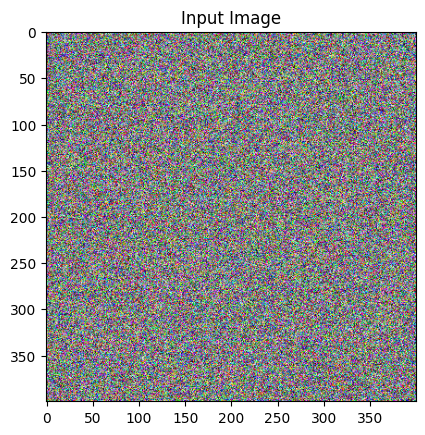

Building the style transfer model..


<ipython-input-10-2fe43a3b65d1>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-10-2fe43a3b65d1>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
<ipython-input-6-791f2c0c4bc1>:8: UserWarning: Using a target size (torch.Size([1, 128, 200, 200])) that is different to the input size (torch.Size([2, 128, 200, 200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss = F.mse_loss(input, self.target)


Optimizing..
run [50]:
Style Loss : 18.094551 Content Loss: 34.306801

run [100]:
Style Loss : 6.815559 Content Loss: 26.337671



In [ ]:
#input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
input_img = torch.randn(content_img.data.size(), device=device)

style_imgs = torch.cat([style1_img, style2_img])
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, input_img, num_steps=100, style1_weight=0.4, style2_weight=0.6)

In [ ]:
if 0:
  plt.figure()
  imshow(output, title='Output Image')
  plt.ioff()
  plt.show()
  # s3-s6 num_steps=500, style1_weight=0.5, style2_weight=0.5

In [ ]:
if 0:
  plt.figure()
  imshow(output, title='Output Image')
  plt.ioff()
  plt.show()
  # s2-s4 num_steps=500, style1_weight=0.5, style2_weight=0.5

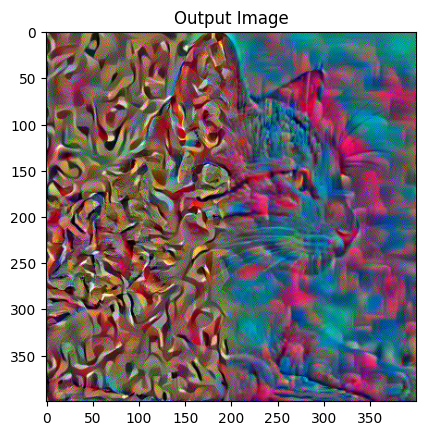

In [ ]:
if 1:
  plt.figure()
  imshow(output, title='Output Image')
  plt.ioff()
  plt.show()
  # s1-s5 num_steps=500, style1_weight=0.5, style2_weight=0.5